In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc,precision_recall_curve,roc_curve,confusion_matrix
import os,sys
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
np.random.seed(10)
random.seed(10)

## The Network

In [2]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d

import torch.optim as optim
from sklearn.metrics import accuracy_score,recall_score,f1_score

In [3]:
def compute_conv_dim(dim_size,kernel_size,padding,stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)
compute_conv_dim(34,2,0,1)

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight.data, 1)
          nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
          if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

In [4]:
# hyperameters of the model
# Peptide [batch_size, input_channels, input_height, input_width] > [batch_size, 1, 10, 12]
peptide_input_channels = 1
peptide_input_height = 10
peptide_input_width = 12

# Peptide [batch_size, input_channels, input_height, input_width] > [batch_size, 1, 34, 12]
hla_input_channels = 1
hla_input_height = 34
hla_input_width = 12

# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Self-attention models
        self.peptide_attention = nn.MultiheadAttention(embed_dim=12,num_heads=1,dropout=0.4)
        self.HLA_atttention = nn.MultiheadAttention(embed_dim=12,num_heads=1,dropout=0.4)


        # Convelution of peptide
        self.conv1_peptide = Conv2d(in_channels=peptide_input_channels,
                            out_channels=16,
                            kernel_size=(2,12),
                            stride=1,
                            padding=0)
        
        self.BatchNorm_conv1_peptides = BatchNorm2d(16,track_running_stats=False) # Output channels from the previous layer
        self.conv2_peptide = Conv2d(in_channels=16,
                            out_channels=32,
                            kernel_size=(2,1),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv2_peptides = BatchNorm2d(32,track_running_stats=False) # Output channels from the previous layer
        self.maxpool1_peptide = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)

        
        # Convelution of HLA
        self.conv1_HLA = Conv2d(in_channels=peptide_input_channels,
                            out_channels=16,
                            kernel_size=(2,12),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv1_HLA = BatchNorm2d(16,track_running_stats=False) # Output channels from the previous layer
        self.maxpool1_HLA = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)
        
        self.conv2_HLA = Conv2d(in_channels=16,
                            out_channels=32,
                            kernel_size=(9,1),
                            stride=1,
                            padding=0)
        self.BatchNorm_conv2_HLA = BatchNorm2d(32,track_running_stats=False) # Output channels from the previous layer
        self.maxpool2_HLA = nn.MaxPool2d(kernel_size=(2,1), stride=(2,1), padding=0)

        
        # Denselayer
        self.L_in = Linear(in_features=256,
                            out_features=132)
        
        self.batch_norm_linear1 = BatchNorm1d(132,track_running_stats=False)
        self.drop_out = nn.Dropout(p=0.4)

        self.L_2 = Linear(in_features=132 + 256,
                        out_features=66)
        self.batch_norm_linear2 = BatchNorm1d(66,track_running_stats=False)

        self.L_3 = Linear(in_features=66 + 132 + 256,
                        out_features=33)
        self.batch_norm_linear3= BatchNorm1d(33,track_running_stats=False)


        self.L_out = Linear(in_features=33,
                            out_features=2,
                            bias=False)



        # Denselayer
        # self.L_in = Linear(in_features=256, # 161 if bingding score
        #                     out_features=132)
        # self.drop_out = nn.Dropout(p=0.4)
        # self.L_out = Linear(in_features=160,
        #                     out_features=2,
        #                     bias=False)

    def forward(self, peptide, HLA, binding_score=None): # x.size() = [batch, channel, height, width]
        
        # Context embedding of peptides and HLA
        context_embedded_peptide, attn_weights_peptide = self.peptide_attention(peptide,peptide,peptide)
        context_embedded_hla, attn_weights_HLA = self.HLA_atttention(HLA,HLA,HLA)
        context_embedded_peptide = context_embedded_peptide.reshape(context_embedded_peptide.shape[0],1,context_embedded_peptide.shape[1],context_embedded_peptide.shape[2])
        context_embedded_hla = context_embedded_hla.reshape(context_embedded_hla.shape[0],1,context_embedded_hla.shape[1],context_embedded_hla.shape[2])


        # Encoding the peptide
        peptide = self.conv1_peptide(context_embedded_peptide)
        peptide = self.BatchNorm_conv1_peptides(peptide)
        peptide = relu(peptide)

        peptide = self.conv2_peptide(peptide)
        peptide = self.BatchNorm_conv2_peptides(peptide)
        peptide = relu(peptide)

        peptide = self.maxpool1_peptide(peptide)
        peptide = self.BatchNorm_conv2_peptides(peptide)
        peptide = torch.flatten(peptide,start_dim=1)



        # Encoding the HLA
        HLA = self.conv1_HLA(context_embedded_hla)
        HLA = self.BatchNorm_conv1_HLA(HLA)
        HLA = relu(HLA)
        HLA = self.maxpool1_HLA(HLA)
        HLA = self.conv2_HLA(HLA)
        HLA = self.BatchNorm_conv2_HLA(HLA)
        HLA = relu(HLA)
        HLA = self.maxpool2_HLA(HLA)
        HLA = torch.flatten(HLA,start_dim=1)

        # Combining the output
        # First layer of Dense
        combined_input = torch.cat((peptide, HLA), 1)
        in_layer = self.L_in(combined_input)
        in_layer = relu(in_layer)
        in_layer = self.batch_norm_linear1(in_layer)
        in_layer = self.drop_out(in_layer)

        # Second layer of Dense
        combined_input_2 = torch.cat((peptide, HLA, in_layer), 1)
        l2_layer = self.L_2(combined_input_2)
        l2_layer = relu(l2_layer)
        l2_layer = self.batch_norm_linear2(l2_layer)
        l2_layer = self.drop_out(l2_layer)

        # Third layer of dense
        combined_input_3 = torch.cat((peptide, HLA, in_layer,l2_layer), 1)
        l3_layer = self.L_3(combined_input_3)
        l3_layer = relu(l3_layer)
        l3_layer = self.batch_norm_linear3(l3_layer)
        l3_layer = self.drop_out(l3_layer)


        x = self.L_out(l3_layer)
        x = relu(x)
        return softmax(x, dim=1)
        


net = Net()
net.apply(initialize_weights)
print(net)

Net(
  (peptide_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
  )
  (HLA_atttention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
  )
  (conv1_peptide): Conv2d(1, 16, kernel_size=(2, 12), stride=(1, 1))
  (BatchNorm_conv1_peptides): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2_peptide): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1))
  (BatchNorm_conv2_peptides): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (maxpool1_peptide): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv1_HLA): Conv2d(1, 16, kernel_size=(2, 12), stride=(1, 1))
  (BatchNorm_conv1_HLA): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (maxpool1_HLA): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation

In [5]:
peptide_random = np.random.normal(0,1, (10, 10, 12)).astype('float32')
peptide_random = Variable(torch.from_numpy(peptide_random))
HLA_random = np.random.normal(0,1, (10, 34, 12)).astype('float32')
HLA_random = Variable(torch.from_numpy(HLA_random))
binding_random = np.random.normal(0,1, (10, 1)).astype('float32')
binding_random = Variable(torch.from_numpy(binding_random))


output = net(peptide_random,HLA_random,binding_random)
output

tensor([[0.1379, 0.8621],
        [0.1373, 0.8627],
        [0.5000, 0.5000],
        [0.1322, 0.8678],
        [0.0706, 0.9294],
        [0.0172, 0.9828],
        [0.7313, 0.2687],
        [0.5000, 0.5000],
        [0.9040, 0.0960],
        [0.2568, 0.7432]], grad_fn=<SoftmaxBackward0>)

## Functions for loading data

In [6]:

def encode_peptide_aaindex(aa_seq,aaindex_PCA,row):
    aa_seq = list(aa_seq.upper())
    encoded_aa_seq = []
    PCs = aaindex_PCA.shape[1]
    for aa in aa_seq:
        if aa == "X" or aa == "-":
            encoded_aa_seq.append(np.array([0 for x in range(PCs)]))
        else:
            try:
                encoded_aa_seq.append(aaindex_PCA.loc[aa].to_numpy())
            except KeyError:
                print(row)
                sys.exit(1)
    return np.array(encoded_aa_seq)

def encode_dataset(df,aaindex_PCA,HLA_dict,peptide_len,padding="right"):
    encoded_peptides = []
    encoded_labels = []
    encoded_hlas = []
    encoded_binding_scores = []
    for i,row in df.iterrows():
        peptide = row["peptide"]
        HLA = HLA_dict[row["HLA_allele"].replace(":","")]
        encoded_peptide = encode_peptide_aaindex(peptide,aaindex_PCA,row)
        binding_score = row['binding_score']
        
        # Adding padding
        if len(encoded_peptide) < peptide_len:
            n_added = peptide_len-len(encoded_peptide)
            if padding == "right":
                encoded_peptide = np.pad(encoded_peptide, ((0, 1), (0, 0)), 'constant')
            elif padding == "left":
                encoded_peptide = np.pad(encoded_peptide, ((1, 0), (0, 0)), 'constant')
            elif padding == "random":
                top_pad = random.choice([0,1])
                bot_pad = 1-top_pad
                encoded_peptide = np.pad(encoded_peptide, ((top_pad, bot_pad), (0, 0)), 'constant')


        encoded_HLA = encode_peptide_aaindex(HLA,aaindex_PCA,row)
        encoded_label = min(1,row["positive_subjects"])
        encoded_peptides.append(encoded_peptide)
        encoded_hlas.append(encoded_HLA)
        encoded_labels.append(encoded_label)
        encoded_binding_scores.append(binding_score)
    
    encoded_peptides = np.array(encoded_peptides).astype('float32')
    encoded_hlas = np.array(encoded_hlas).astype('float32')
    encoded_labels = np.array(encoded_labels).astype('float32')
    encoded_binding_scores = np.array(encoded_binding_scores).astype('float32')
    return encoded_peptides, encoded_hlas, encoded_binding_scores, encoded_labels


## Functions for training the models

In [7]:
def plot_learning_curve(train_accuracies,val_accuracies):
    epoch = np.arange(len(train_accuracies))
    plt.figure()
    plt.plot(epoch, train_accuracies, 'r', epoch, val_accuracies, 'b')
    plt.legend(['Train Accucary','Validation Accuracy'])
    plt.xlabel('epochs'), plt.ylabel('Acc')

def validation(model,device,valid_loaders,train_loaders):
    peptide_val_loader,HLA_val_loader,label_val_loader,binding_score_val_loader = valid_loaders
    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
    model.eval()
    with torch.no_grad():
        all_train_targets = []
        all_predicted_train_labels = []
        for i in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[i].to(device)
            train_HLA = HLA_train_loader[i].to(device)
            train_labels = label_train_loader[i].long().to(device)
            train_binding_scores = binding_score_train_loader[i].to(device)
            outputs = model(train_peptides,train_HLA,train_binding_scores)
            _,predicted_labels =  torch.max(outputs, 1)

            all_predicted_train_labels += predicted_labels.numpy().tolist()
            all_train_targets += train_labels.numpy().tolist()
        
        all_val_targets = []
        all_predicted_val_labels = []
        all_probabilities_val = []
        for j in range(len((peptide_val_loader))):
            val_peptides = peptide_val_loader[j].to(device)
            val_HLA = HLA_val_loader[j].to(device)
            val_labels = label_val_loader[j].long().to(device)
            val_binding_scores = binding_score_val_loader[j].to(device)


            outputs = model(val_peptides,val_HLA,val_binding_scores)
            probability,predicted_labels =  torch.max(outputs, 1)
            all_predicted_val_labels += predicted_labels.numpy().tolist()
            all_val_targets += val_labels.numpy().tolist()
            all_probabilities_val += probability.numpy().tolist()

    return all_train_targets,all_predicted_train_labels,all_val_targets,all_predicted_val_labels,all_probabilities_val


def train(model, device, epochs, train_loaders, valid_loaders):
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-4)
    # Early stopping
    the_last_loss = 100
    patience = 100
    trigger_times = 0
    
    all_val_targets_pr_epoch = []
    all_val_predictions_pr_epoch = []
    all_val_probabilities_pr_epoch = []
    losses = []

    train_accuracies = []
    val_accuracies = []

    peptide_train_loader,HLA_train_loader,label_train_loader,binding_score_train_loader = train_loaders
        
    for epoch in range(epochs):
        model.train()
        current_loss = 0
        for train_batch_index in range(len((peptide_train_loader))):
            train_peptides = peptide_train_loader[train_batch_index].to(device)
            train_HLA = HLA_train_loader[train_batch_index].to(device)
            train_labels = label_train_loader[train_batch_index].long().to(device)
            train_binding_scores = binding_score_train_loader[train_batch_index].to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model(train_peptides,train_HLA,train_binding_scores)
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()
            current_loss += loss.item()
        losses.append(current_loss/len((peptide_train_loader)))

        all_train_targets,all_predicted_train_labels,all_val_targets,all_predicted_val_labels,all_probabilities_val = validation(model,device,valid_loaders,train_loaders)
    
        # Calculating the accuracies
        train_accuracies.append(accuracy_score(all_train_targets,all_predicted_train_labels))
        val_accuracies.append(accuracy_score(all_val_targets,all_predicted_val_labels))
        # Saving the predicitons for further validation
        all_val_targets_pr_epoch.append(all_val_targets)
        all_val_predictions_pr_epoch.append(all_predicted_val_labels)
        all_val_probabilities_pr_epoch.append(all_probabilities_val)

        if epoch % 10 == 0:
            print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (epoch+1, losses[-1], train_accuracies[-1], val_accuracies[-1]))
        

        # Early stopping
        the_current_loss = val_accuracies[-1]
        the_last_loss = 0 if len(val_accuracies) < 2 else val_accuracies[-2]

        # print('The current valdiation loss:', the_current_loss)

        if the_current_loss < the_last_loss:
            trigger_times += 1
            # print('trigger times:', trigger_times)

            if trigger_times >= patience:
                # print('Early stopping at epoch',epoch)
                return model,train_accuracies,val_accuracies,all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_val_probabilities_pr_epoch

        else:
            # print('trigger times: 0')
            trigger_times = 0

    return model,train_accuracies,val_accuracies,all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_val_probabilities_pr_epoch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device state:', device)




Device state: cpu


## 5-fold cross-validation loop

In [8]:
# Loading the databases
aaindex_PCA = pd.read_csv('../data/PCA_repr_aa.csv',index_col=0)
hla_database = pd.read_csv('../data/formatted_hla2paratope_MHC_pseudo.dat', sep=' ',index_col=0)
hla_dic = hla_database.to_dict("dict")["pseudo"]

all_data = pd.read_csv("../data/filtered_data_IEDB_4_tested_len_9_10_full_HLA_Multi_assay_w_binding_w_parts.csv")
all_data = all_data.sample(frac=1, random_state=1).reset_index(drop=True)

testing = False
part_dict = {0:[0,1], 1:[2,3], 2:[4,5], 3:[6,7], 4:[8,9]}
partitions = [0,1,2,3,4,5,6,7,8,9]

batch_size = 100
epochs = 150
lst_val_accuracies = []
lst_train_accuracies = []
lst_val_predictions = []
lst_val_labels = []
lst_val_probabilities = []

lst_test_accuracies = []
lst_test_predictions = []
lst_test_labels = []
lst_test_probabilities = []

for i in range(5):
    if testing == True:
        ## The partitions to use for training, validation ##
        testing_parts = [0]
        validation_parts = [partitions[1:][i]]
        training_parts = [j for j in range(1,10) if j not in validation_parts]
        print("the val and train parts")
        print(validation_parts, training_parts)

        ## The actual data frames ##
        training_df = all_data[all_data["parts"].isin(training_parts)]
        validation_df = all_data[all_data["parts"].isin(validation_parts)]
        testing_df = all_data[all_data["parts"].isin(testing_parts)]

        ## Encoding the data frames ##
        print("##Encoding Testing data")
        test_peptides_encoded,test_HLA_encoded,test_binding_scores_encoded,test_label_encoded = encode_dataset(testing_df,aaindex_PCA,hla_dic,peptide_len=10,padding="right")
       
        peptide_test = test_peptides_encoded.reshape(-1,1,10,12)
        HLA_test = test_HLA_encoded.reshape(-1,1,34,12) # 46 aligned representataion and 34 if not aligned
        binding_test = test_binding_scores_encoded.reshape(-1,1)
        label_test = test_label_encoded.reshape(-1)

        peptide_test_loader = list(DataLoader(peptide_test,batch_size=batch_size))
        HLA_test_loader = list(DataLoader(HLA_test,batch_size=batch_size))
        label_test_loader = list(DataLoader(label_test,batch_size=batch_size))
        binding_score_test_loader = list(DataLoader(binding_test,batch_size=batch_size))

    else:

        ## The partitions to use for training, validation ##
        validation_parts = part_dict[i]
        training_parts = [j for j in range(10) if j not in validation_parts]
        print("the val and train parts")
        print(validation_parts, training_parts)

        ## The actual data frames ##
        training_df = all_data[all_data["parts"].isin(training_parts)]
        validation_df = all_data[all_data["parts"].isin(validation_parts)]

    ## Encoding the data frames ##
    print("##Encoding Training data")
    train_peptides_encoded,train_HLA_encoded,train_binding_scores_encoded,train_label_encoded = encode_dataset(training_df,aaindex_PCA,hla_dic,peptide_len=10,padding="right")
    print("##Encoding Validation data")
    val_peptides_encoded,val_HLA_encoded,val_binding_scores_encoded ,val_label_encoded = encode_dataset(validation_df,aaindex_PCA,hla_dic,peptide_len=10,padding="right")

    ## Reshaping everything ##
    peptide_train = train_peptides_encoded.reshape(-1,10,12)
    HLA_train = train_HLA_encoded.reshape(-1,34,12)
    binding_train = train_binding_scores_encoded.reshape(-1,1)
    label_train = train_label_encoded.reshape(-1)

    peptide_val = val_peptides_encoded.reshape(-1,10,12)
    HLA_val = val_HLA_encoded.reshape(-1,34,12) # 46 aligned representataion and 34 if not aligned
    binding_val = val_binding_scores_encoded.reshape(-1,1)
    label_val = val_label_encoded.reshape(-1)


    ## Batches for training the model ##
    peptide_train_loader = list(DataLoader(peptide_train,batch_size=batch_size))
    HLA_train_loader = list(DataLoader(HLA_train,batch_size=batch_size))
    label_train_loader = list(DataLoader(label_train,batch_size=batch_size))
    binding_score_train_loader = list(DataLoader(binding_train,batch_size=batch_size))

    peptide_val_loader = list(DataLoader(peptide_val,batch_size=batch_size))
    HLA_val_loader = list(DataLoader(HLA_val,batch_size=batch_size))
    label_val_loader = list(DataLoader(label_val,batch_size=batch_size))
    binding_score_val_loader = list(DataLoader(binding_val,batch_size=batch_size))


    train_loaders = (peptide_train_loader, HLA_train_loader, label_train_loader, binding_score_train_loader)
    val_loaders = (peptide_val_loader, HLA_val_loader, label_val_loader, binding_score_val_loader)

    net = Net()
    net.apply(initialize_weights)

    trained_model,train_accuracies,val_accuracies,all_val_targets_pr_epoch,all_val_predictions_pr_epoch,all_val_probabilities_pr_epoch= train(net,device,epochs,train_loaders,val_loaders)
    lst_train_accuracies.append(train_accuracies)
    lst_val_accuracies.append(val_accuracies)
    lst_val_predictions.append(np.array(all_val_predictions_pr_epoch))
    lst_val_labels.append(np.array(all_val_targets_pr_epoch))
    lst_val_probabilities.append(np.array(all_val_probabilities_pr_epoch))
    
    if testing == True:
        test_outputs = trained_model(peptide_test_loader[0],HLA_test_loader[0],binding_score_test_loader[0])
        print(test_outputs)
    

the val and train parts
[0, 1] [2, 3, 4, 5, 6, 7, 8, 9]
##Encoding Training data
##Encoding Validation data
Epoch  1 : Train Loss 0.704045 , Train acc 0.580471, Valid acc 0.570418


KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

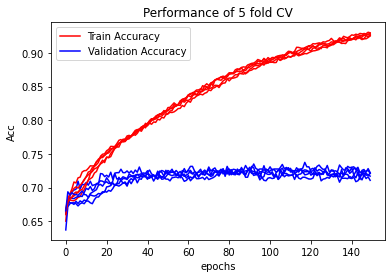

In [ ]:
plt.figure()
for i in range(5):
    epoch = np.arange(len(lst_train_accuracies[i]))
    plt.plot(epoch, lst_train_accuracies[i], 'r', epoch, lst_val_accuracies[i], 'b')
plt.title("Performance of 5 fold CV")
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.xlabel('epochs'), plt.ylabel('Acc')
plt.show()
#plt.savefig("../plots/FFNN_3_layers_bigthensmall_btchnrm_drpt_bndscr.png", dpi = 400, transparent = False)

In [ ]:
N = len(all_data)

def calculate_avg_performance(lst_val_acc, lst_val_lab, lst_val_pred, N):
    """Calculate the generalization error

    Args:
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
        N (int): Total number of observations in data set
    """
    avg_recall = 0
    avg_accuracy = 0 
    avg_f1 = 0

    res = np.zeros((5,5))
    for i in range(5):
        best_epoch_model = np.argmax(lst_val_acc[i])
        n = len(lst_val_lab[i][best_epoch_model])
        accuracy = accuracy_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])
        recall = recall_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])
        f1 = f1_score(lst_val_lab[i][best_epoch_model],lst_val_pred[i][best_epoch_model])

        res[i][0] = best_epoch_model
        res[i][1] = n
        res[i][2] = accuracy
        res[i][3] = recall
        res[i][4] = f1

        avg_recall += (n/N) * recall
        avg_accuracy += (n/N) * accuracy
        avg_f1 += (n/N) * f1

    print(f"Best average results - Recall: {avg_recall} accuracy: {avg_accuracy} f1-score: {avg_f1}")
    return res

result_mtrx = calculate_avg_performance(lst_val_accuracies, lst_val_labels, lst_val_predictions, N)

Best average results - Recall: 0.7310816025521798 accuracy: 0.7333420263398096 f1-score: 0.7374534226899925


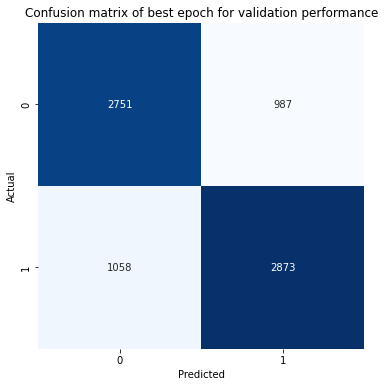

In [ ]:
def k_fold_confusion_matrix(lst_val_acc, lst_val_lab, lst_val_pred):
    """Plot the overall confusion matrix for 5 fold CV

    Args:
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
    """
    all_labels = []
    all_predictions = []
    for i in range(5):
        best_epoch_model = np.argmax(lst_val_acc[i])
        all_labels.extend(lst_val_lab[i][best_epoch_model])
        all_predictions.extend(lst_val_pred[i][best_epoch_model])

    fig = plt.figure(figsize=(10,6))
    plt.title("Confusion matrix of best epoch for validation performance")
    conf_mat = confusion_matrix(all_labels,all_predictions)
    sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

k_fold_confusion_matrix(lst_val_accuracies, lst_val_labels, lst_val_predictions)

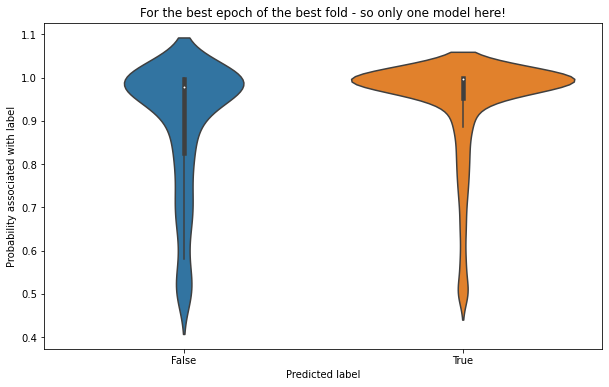

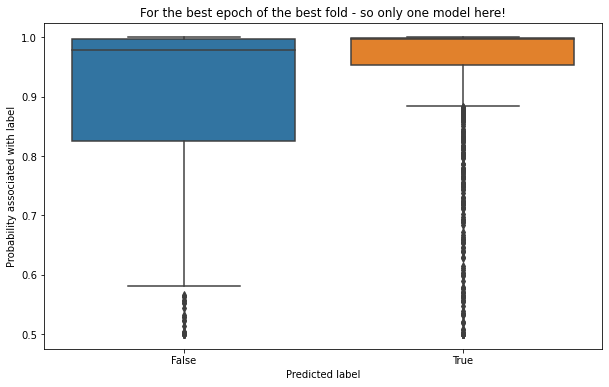

In [ ]:
def violin_best_fold(res_mtrx, lst_val_acc, lst_val_lab, lst_val_pred, lst_val_prob):
    """For the best fold, find the best epoch, and plot the violin plot

    Args:
        res_mtrx (matrix): result matrix from calculate_avg_performance
        lst_val_acc (list of lists): list of lists containing validation accuracies for each fold
        lst_val_lab (list of lists): list of lists containing validation labels for each fold
        lst_val_pred (list of lists): list of lists containing validation predictions for each fold
        lst_val_prob (list of lists): list of lists containing validation probabilities for each fold
    """
    best_fold = np.argmax(res_mtrx[:,2])
    best_epoch_model = np.argmax(lst_val_acc[best_fold])
    labels_best_epoch = lst_val_lab[best_fold][best_epoch_model]
    predictions_best_epoch = lst_val_pred[best_fold][best_epoch_model]
    probabilities_best_epoch = lst_val_prob[best_fold][best_epoch_model]
    true_predictions = [x==y for x,y in zip(labels_best_epoch,predictions_best_epoch)]
    dataframe = pd.DataFrame()
    dataframe["Probs"] = probabilities_best_epoch
    dataframe["Predictions"] = predictions_best_epoch
    dataframe["Labels"] = labels_best_epoch
    dataframe["True"] = true_predictions    

    plt.figure(figsize=(10,6))
    ax = sns.violinplot(x="True", y="Probs", data=dataframe)
    plt.title("For the best epoch of the best fold - so only one model here!")
    plt.xlabel("Predicted label")
    plt.ylabel("Probability associated with label")
    plt.show()

    plt.figure(figsize=(10,6))
    ax = sns.boxplot(x="True", y="Probs", data=dataframe)
    plt.title("For the best epoch of the best fold - so only one model here!")
    plt.xlabel("Predicted label")
    plt.ylabel("Probability associated with label")
    plt.show()
        

violin_best_fold(result_mtrx, lst_val_accuracies, lst_val_labels, lst_val_predictions, lst_val_probabilities)